In [12]:
##########데이터 로드import pathlib
# !pip install openpyxl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

print(tf.__version__)

2.8.0


## Loading data

In [7]:
train_df = pd.read_excel('https://github.com/cranberryai/todak_todak_python/blob/master/machine_learning/regression/carprice_E1SUl6b.xlsx?raw=true', sheet_name='train')
test_df = pd.read_excel('https://github.com/cranberryai/todak_todak_python/blob/master/machine_learning/regression/carprice_E1SUl6b.xlsx?raw=true', sheet_name='test')

In [19]:
print(train_df.isna().sum(), test_df.isna().sum())

가격       0
년식       0
종류       0
연비       0
마력       0
토크       0
연료       0
하이브리드    0
배기량      0
중량       0
변속기      0
dtype: int64 가격       0
년식       0
종류       0
연비       0
마력       0
토크       0
연료       0
하이브리드    0
배기량      0
중량       0
변속기      0
dtype: int64


In [11]:
x_train_df = train_df.drop(['가격'], axis=1)
x_test_df = test_df.drop(['가격'], axis=1)
y_train_df = train_df['가격']
y_test_df = test_df['가격']

print(x_train_df.head())

     년식   종류    연비   마력    토크   연료  하이브리드   배기량    중량 변속기
0  2015  준중형  11.8  172  21.0  가솔린      0  1999  1300  자동
1  2015  준중형  12.3  204  27.0  가솔린      0  1591  1300  자동
2  2015   소형  15.0  100  13.6  가솔린      0  1368  1035  수동
3  2014   소형  14.0  140  17.0  가솔린      0  1591  1090  자동
4  2015   대형   9.6  175  46.0   디젤      0  2497  1990  자동


In [27]:
x_train_df['종류'].value_counts() #대형,소형,준중형, 중형
x_train_df['연료'].value_counts() # 가솔린, 디젤, LPG
x_train_df['변속기'].value_counts() # 자동, 수동

변속기
자동    51
수동    20
Name: count, dtype: int64

In [31]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['종류', '연료', '변속기']),
    remainder='passthrough') # drop이 default

transformer.fit(x_train_df)
x_train = transformer.transform(x_train_df)
x_train[0]

# array([0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
#        0.000e+00, 0.000e+00, 1.000e+00, 2.015e+03, 1.180e+01, 1.720e+02,
#        2.100e+01, 0.000e+00, 1.999e+03, 1.300e+03])
#  ==    [0 0 1 0] [0 1 0] [0 1] 2015 11.8 172 21 0 1999 1300
# 0  2015  준중형(종류)  11.8  172  21.0  가솔린(연료)      0  1999  1300  자동(변속기)
# 종류 [0 0 1 0], 연료[0 1 0], 변속기 [0 1]

x_test = transformer.transform(x_train_df)

In [34]:
import numpy as np
np.mean(x_train)

372.99665492957746

In [37]:
def norm(x):
    return (x - np.mean(x_train)) / np.std(x_train)
normed_train_data = norm(x_train)
normed_test_data = norm(x_test)

In [73]:
np.shape(x_train)

(71, 16)

In [74]:
# len(x_train_df.keys())

10

## Building the Model

In [136]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[16]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(100)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'acc'])
    return model
model = build_model()

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.22726093],
       [0.16416596],
       [0.16021943],
       [0.17514846],
       [0.40050787],
       [0.33766463],
       [0.3281957 ],
       [0.16346228],
       [0.25444078],
       [0.1637625 ]], dtype=float32)

## 모델 훈련

In [140]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
    normed_train_data, y_train_df,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [120]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,acc,val_loss,val_mae,val_mse,val_acc,epoch
995,181008.500000,341.350616,181008.500000,0.0,1353929.875,628.641296,1353929.875,0.0,995
996,177564.609375,333.980743,177564.609375,0.0,1301131.125,610.777710,1301131.125,0.0,996
997,181245.218750,350.477203,181245.218750,0.0,1235236.375,593.216919,1235236.375,0.0,997
998,178463.765625,356.456360,178463.765625,0.0,1274286.000,603.233704,1274286.000,0.0,998
999,175115.390625,344.467224,175115.390625,0.0,1343566.375,624.745544,1343566.375,0.0,999


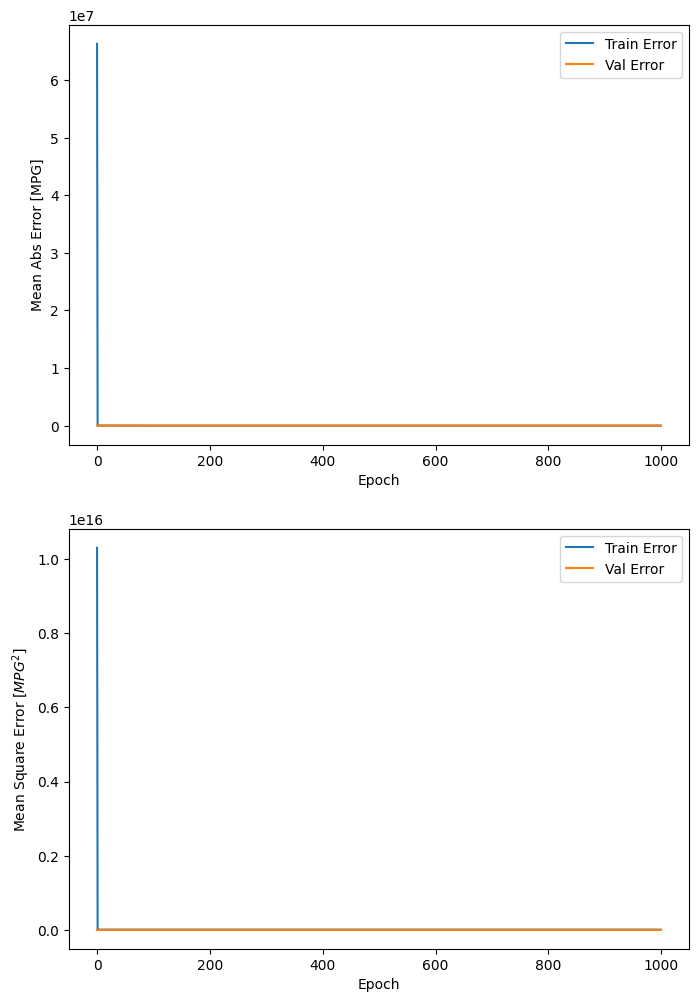

In [134]:
import matplotlib.pyplot as plt

def plot_history(history):
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        plt.figure(figsize=(8,12))

        plt.subplot(2,1,1)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Abs Error [MPG]')
        plt.plot(hist['epoch'], hist['mae'],
                label='Train Error')
        plt.plot(hist['epoch'], hist['val_mae'],
                label = 'Val Error')
        # plt.ylim([0,5])
        plt.legend()

        plt.subplot(2,1,2)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error [$MPG^2$]')
        plt.plot(hist['epoch'], hist['mse'],
                label='Train Error')
        plt.plot(hist['epoch'], hist['val_mse'],
                label = 'Val Error')
        # plt.ylim([0,20])
        plt.legend()
        plt.show()

plot_history(history)